In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import numpy as np
import io
import os

## Old logs

In [18]:
data = pd.read_csv("../../BenchmarkCosimo/logs/bin_vs_2bits_vs_dnnl.csv",  sep="\t", index_col=False)
data["M"] = data["M"].astype(int)

In [21]:
old_times = data [ data['lib'] == "Bin Kernel 512 8x8"]['min_elapsed'].values

In [22]:
new_times = new_data['min_elapsed'].values

In [24]:
old_times[:len(new_times)] - new_times

array([   -595,    1925,     294,      -9,     343,    2678,    -197,
          1883,    2785,    7290,    4399,    4018,    5260,   15329,
          8473,    2658,   -6570,    1993,   -2923,    -628,    5057,
        -16225,   -9248,   -2759,    2708,     598,    -342, -276190,
        -13832,    -675,  -11571,  -11677,  -26042,  -11619,  -11035,
         41168,   18576])

In [13]:
new_data = pd.read_csv("../table4.csv", sep="\t", index_col=False)

In [3]:
#sns.lineplot(x="M", y= "min_elapsed", hue="lib", data=data)

In [25]:
gflops_dense = 3.4 * 16 * 2
gflops_bin = 3.4 * 2048 / 6
gflops_1_2 = gflops_bin / 2
gflops_2_2 = gflops_bin / 8
data = data.assign(gflops = lambda x:  (x["M"] * x["N"] * x["K"]) / x["min_elapsed"])


In [57]:
gflops_dense

108.8

In [34]:
selected_vals = [64, 128, 256, 512, 1024, 2048]

In [54]:
current_df = data[data.lib =="Intel oneDNN"]

In [55]:
current_df[current_df.M.isin(selected_vals)].gflops.values.round()

array([39., 44., 71., 72., 94., 95.])

In [56]:
data[data.lib =="Bin Kernel 512 8x8"]['gflops']  / gflops_bin
data[data.lib =="kernel8x8 64 bit"]['gflops']  / gflops_1_2
data[data.lib == "kernel 2/2 8x8"]['gflops'] / gflops_2_2
data[data.lib == "Intel oneDNN"]['gflops'] / gflops_dense

1      0.354638
5      0.404969
9      0.694674
13     0.655282
17     0.683203
21     0.698359
25     0.660684
29     0.661866
33     0.685333
37     0.668350
41     0.676389
45     0.675561
49     0.661895
53     0.667053
57     0.672258
61     0.863532
65     0.899553
69     0.903972
73     0.878681
77     0.891322
81     0.906933
85     0.894570
89     0.903640
93     0.894208
97     0.885833
101    0.897051
105    0.903779
109    0.888976
113    0.899891
117    0.901493
121    0.884711
125    0.873336
129    0.902191
133    0.894926
137    0.901889
141    0.895311
145    0.887702
149    0.896192
153    0.903607
157    0.881792
Name: gflops, dtype: float64

In [58]:
data

,lib,M,K,N,min_elapsed,mean_elapsed,gflops
0,Bin Kernel 512 8x8,64,64,64,992,1.051910e+03,264.258065
1,Intel oneDNN,64,64,64,6794,6.875480e+03,38.584634
2,kernel8x8 64 bit,64,64,64,1700,1.750480e+03,154.202353
3,kernel 2/2 8x8,64,64,64,9413,9.728890e+03,27.849145
4,Bin Kernel 512 8x8,128,128,128,5184,5.359310e+03,404.543210
...,...,...,...,...,...,...,...
155,kernel 2/2 8x8,2496,2496,2496,199687901,2.027450e+08,77.872119
156,Bin Kernel 512 8x8,2560,2560,2560,15674518,1.573910e+07,1070.349723
157,Intel oneDNN,2560,2560,2560,174873759,1.751910e+08,95.939014
158,kernel8x8 64 bit,2560,2560,2560,67897863,6.821950e+07,247.094905


In [7]:
sns.set_palette(sns.color_palette("Set2"))
palette = sns.color_palette("Set2")

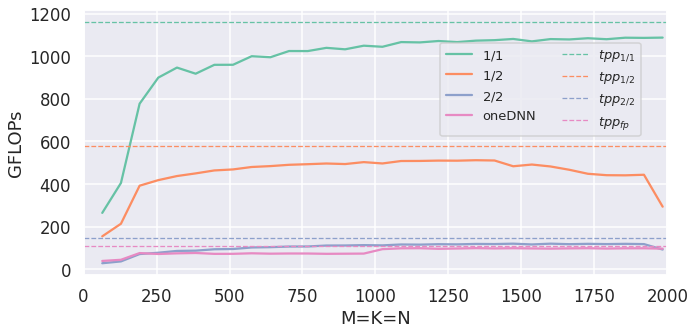

In [21]:
sns.set_style('darkgrid')
sns.set_context("talk")

plt.figure(figsize=(10,5))
xlim = 2000
data = data[data.M <=xlim]
data = data.assign(gflops = lambda x:  (x["M"] * x["N"] * x["K"]) / x["min_elapsed"])

order = ["Bin Kernel 512 8x8", "kernel8x8 64 bit", "kernel 2/2 8x8", "Intel oneDNN"]
sns.lineplot(x="M", y= "gflops", hue="lib", data=data, hue_order=order)
# gflops dense  = 3.4 * 16 * 2 (clock frequency * simd_length * tp)
lw = 1.3
plt.hlines(gflops_bin, 0, xlim, linestyles="--", linewidth=lw, color=palette[0], label="Peak 1/1")
plt.hlines(gflops_1_2, 0, xlim, linestyles="--", linewidth = lw, color=palette[1], label="Peak 1/2")
plt.hlines(gflops_2_2, 0, xlim, linestyles="--", linewidth = lw, color=palette[2], label="Peak 2/2")

plt.hlines(gflops_dense, 0, 2500, linestyles="--", linewidth = lw, color=palette[3], label="Peak 32/32")

# gflops binary  = 3.3 * 2048 / 6 (see paper)
#plt.hlines(1160.53, 0, 4000, linestyles="--", linewidth=1,  color=palette[4], label="gflops bin (cf = 3.4)")
current_handles, current_labels = plt.gca().get_legend_handles_labels()
new_labels = [r"$1/1$", r"$1/2$", r"$2/2$", "oneDNN", r"$tpp_{1/1}$", r"$tpp_{1/2}$", r"$tpp_{2/2}$", r"$tpp_{fp}$"]
#new_labels = ["1/1", "32/32", current_labels[2], current_labels[3]]

#plt.legend(current_handles, new_labels, bbox_to_anchor=(1.02, 1), loc='upper left',)
plt.legend(current_handles, new_labels, ncol=2, prop={"size": 13}, bbox_to_anchor=(0.6,0.5))

plt.xlabel("M=K=N")
plt.ylabel("GFLOPs")
plt.xlim([0, xlim])
plt.tight_layout()
plt.savefig("bin_vs_dnnl_gflops_flatted.pdf", dpi=300, bbox_inches="tight")

## Normal vs Kernel

In [ ]:
data = pd.read_csv("normal_vs_kernel_binary.csv",  sep="\t", index_col=False)
data["speedup"] = data.groupby('M').min_elapsed.transform(np.max) / data.min_elapsed 

In [ ]:
data

In [ ]:
sns.barplot(data=data, x="M", y="speedup", hue="lib")